# Introduction

## Lab2: Train a Convolutional Neural Network (CNN).

In this Lab session we will learn how to train a CNN from scratch for classifying MNIST digits.

In [34]:
# import necessary libraries
import torch
import torchvision
from torchvision import transforms as T
import torch.nn.functional as F
import torch.nn as nn

### Define LeNet

![network architecture](https://www.researchgate.net/profile/Lucijano-Berus/publication/329891470/figure/fig1/AS:707347647307776@1545656229128/Architecture-of-LeNet-5-a-Convolutional-Neural-Network-for-digits-digits-recognition-An.ppm)

Here we are going to define our first CNN which is **LeNet** in this case. This architecture has been introduced and is detailed in [this article](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf). To construct a LeNet we will be using some convolutional layers followed by some fully-connected layers. The convolutional layers can be simply defined using `torch.nn.Conv2d` module of `torch.nn` package. Details can be found [here](https://pytorch.org/docs/stable/nn.html#conv2d). Moreover, we will use pooling operation to reduce the size of convolutional feature maps. For this case we are going to use `torch.nn.functional.max_pool2d`. Details about maxpooling can be found [here](https://pytorch.org/docs/stable/nn.html#max-pool2d)

Differently from our previous Lab, we will use a Rectified Linear Units (ReLU) as activation function with the help of `torch.nn.functional.relu`, replacing `torch.nn.Sigmoid`. Details about ReLU can be found [here](https://pytorch.org/docs/stable/nn.html#id26).

In [ ]:
class LeNet(torch.nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()

    # input channel =1 , output channels = 6, kernel size = 5
    # input image size = (28, 28) and not 32*32, image output size = (24, 24)
    # TODO
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)

    # input channel = 6, output channels = 16, kernel size = 5
    # input image size = (12, 12), output image size = (8, 8)
    # TODO
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)


    # input dim = 4*4*16 ( H x W x C), output dim = 120
    # TODO
    self.fc1 = nn.Linear(in_features=4*4*16, out_features=120)

    # input dim = 120, output dim = 84
    # TODO
    self.fc2 = nn.Linear(in_features=120,out_features=84)

    # input dim = 84, output dim = 10
    # TODO
    self.fc3 = nn.Linear(in_features=84,out_features=10)

  def forward(self, x):

    # TODO
    x = F.relu(self.conv1(x))
    # Max Pooling with kernel size = 2 (and stride = 2)
    # output size = (12, 12)
    # TODO
    x = F.max_pool2d(x, 2)

    # TODO
    x = F.relu(self.conv2(x))
    # Max Pooling with kernel size = 2 (and stride = 2)
    # output size = (4, 4)
    # TODO
    x = F.max_pool2d(x, 2)

    # flatten the feature maps into a long vector
    x = x.view(x.shape[0], -1)

    # TODO
    x = F.relu(self.fc1(x))          # output size: (batch, 120)
    # TODO
    x = F.relu(self.fc2(x))          # output size: (batch, 84)
    # TODO
    x = self.fc3(x)                  # output size: (batch, 10), without activation
    
    return x

### Define cost function

In [36]:
def get_cost_function():
  cost_function = nn.CrossEntropyLoss()
  return cost_function

### Define the optimizer

We will use SGD with learning rate-lr, weight_decay=wd and  momentum=momentum

In [37]:
def get_optimizer(net, lr, wd, momentum):
  optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd, momentum=momentum)
  return optimizer

### Train and test functions

In [ ]:
def test(net, data_loader, cost_function, device='cpu'):
  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.

  net.eval() # Strictly needed if network contains layers which has different behaviours between train and test
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(data_loader):
      # Load data into GPU
      inputs = inputs.to(device)
      targets = targets.to(device)

      # Forward pass
      outputs = net(inputs)

      # Apply the loss
      loss = cost_function(outputs, targets)

      # Better print something
      samples+=inputs.shape[0]
      cumulative_loss += loss.item() # Note: the .item() is needed to extract scalars from tensors
      _, predicted = outputs.max(1)
      cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100


def train(net,data_loader,optimizer,cost_function, device='cpu'):
  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.


  net.train() # Strictly needed if network contains layers which has different behaviours between train and test
  for batch_idx, (inputs, targets) in enumerate(data_loader):
    # Load data into GPU
    inputs = inputs.to(device)
    targets = targets.to(device)

    # Forward pass
    outputs = net(inputs)

    # Apply the loss
    loss = cost_function(outputs,targets)

    # Reset the optimizer

    # Backward pass
    loss.backward()

    # Update parameters
    optimizer.step()

    optimizer.zero_grad()

    # Better print something, no?
    samples+=inputs.shape[0]
    cumulative_loss += loss.item()
    _, predicted = outputs.max(1)
    cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100

### Define the function that fetches a data loader that is then used during iterative training.

We will learn a new thing in this function as how to Normalize the inputs given to the network.

***Why Normalization is needed***?

To have nice and stable training of the network it is recommended to normalize the network inputs between \[-1, 1\].

***How it can be done***?

This can be simply done using `torchvision.transforms.Normalize()` transform. Details can be found [here](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize).

In [39]:
def get_data(batch_size, test_batch_size=256):

  # Prepare data transformations and then combine them sequentially
  transform = list()
  transform.append(T.ToTensor())                            # converts Numpy to Pytorch Tensor
  transform.append(T.Normalize(mean=[0.5], std=[0.5]))      # Normalizes the Tensors between [-1, 1]
  transform = T.Compose(transform)                          # Composes the above transformations into one.

  # Load data
  full_training_data = torchvision.datasets.MNIST('./data', train=True, transform=transform, download=True)
  test_data = torchvision.datasets.MNIST('./data', train=False, transform=transform, download=True)


  # Create train and validation splits
  num_samples = len(full_training_data)
  training_samples = int(num_samples*0.5+1)
  validation_samples = num_samples - training_samples

  training_data, validation_data = torch.utils.data.random_split(full_training_data, [training_samples, validation_samples])

  # Initialize dataloaders
  train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(validation_data, test_batch_size, shuffle=False)
  test_loader = torch.utils.data.DataLoader(test_data, test_batch_size, shuffle=False)

  return train_loader, val_loader, test_loader

### Wrapping everything up

Finally, we need a main function which initializes everything + the needed hyperparameters and loops over multiple epochs (printing the results).

In [ ]:
'''
Input arguments
  batch_size: Size of a mini-batch
  device: GPU where you want to train your network
  weight_decay: Weight decay co-efficient for regularization of weights
  momentum: Momentum for SGD optimizer
  epochs: Number of epochs for training the network
'''

def main(batch_size=128,
         device='cpu',
         learning_rate=0.01,
         weight_decay=0.000001,
         momentum=0.9,
         epochs=50,
         lenet='1'):

  train_loader, val_loader, test_loader = get_data(batch_size)

  # TODO for defining LeNet-5 and moving it to the GPU
  if lenet=='1':
    net = LeNet().to(device)
  elif lenet=='5':
    net = LeNet5().to(device)
  else :
    print('No net Found')
    return


  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)

  cost_function = get_cost_function()

  print('Before training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  for e in range(epochs):
    train_loss, train_accuracy = train(net, train_loader, optimizer, cost_function)
    val_loss, val_accuracy = test(net, val_loader, cost_function)
    print('Epoch: {:d}'.format(e+1))
    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('-----------------------------------------------------')

  print('After training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')
  return net

Lets train!

In [41]:
net = main(device='cpu')

Before training:
	 Training loss 0.01806, Training accuracy 11.26
	 Validation loss 0.00907, Validation accuracy 11.22
	 Test loss 0.00923, Test accuracy 11.35
-----------------------------------------------------
Epoch: 1
	 Training loss 0.00938, Training accuracy 58.31
	 Validation loss 0.00103, Validation accuracy 92.05
-----------------------------------------------------
Epoch: 2
	 Training loss 0.00133, Training accuracy 94.70
	 Validation loss 0.00062, Validation accuracy 94.98
-----------------------------------------------------
Epoch: 3
	 Training loss 0.00083, Training accuracy 96.66
	 Validation loss 0.00036, Validation accuracy 97.13
-----------------------------------------------------
Epoch: 4
	 Training loss 0.00061, Training accuracy 97.61
	 Validation loss 0.00036, Validation accuracy 97.23
-----------------------------------------------------
Epoch: 5
	 Training loss 0.00052, Training accuracy 97.91
	 Validation loss 0.00036, Validation accuracy 97.20
---------------

---

Check which MNIST digit is most frequently confused with which other digit (e.g. plot a confusion matrix). Can you explain why?



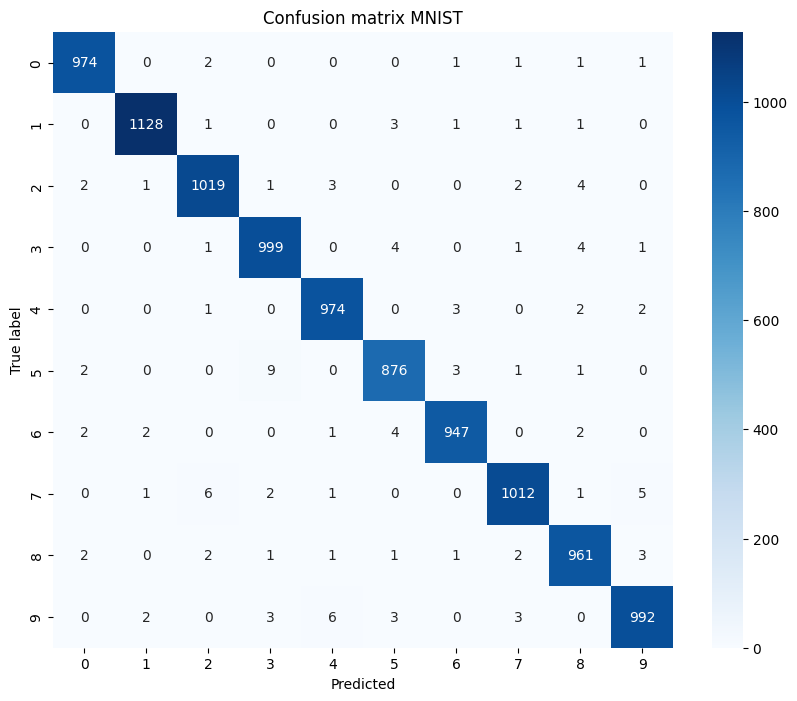

In [54]:

import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def compute_confusion_matrix(model, test_loader, device='cpu'):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    return cm

_, _, test_loader = get_data(batch_size=128, test_batch_size=256)
# Calcul de la matrice
cm = compute_confusion_matrix(net,  test_loader, device='cpu')

# Affichage graphique
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True label')
plt.title('Confusion matrix MNIST')
plt.show()





5 and 3 are most frequently confused with which other digit, maybe because they look alike a lot (kinda the same structure and edge)

---

The LeNet5 architecture can also be implemented using the sequential API ([see documentation](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)). Reimplement it with this API.

In [57]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5),    # (28 - 5 + 1) = 24
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),       # 28 / 2 = 12

            nn.Conv2d(6, 16, kernel_size=5),   # 12 - 5 + 1 = 8
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)        # 8 / 2 = 4
        )

        self.classifier = nn.Sequential(
            nn.Linear(16 * 4 * 4, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)                  # 10 classes pour MNIST
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x


In [59]:
net5=main(device='cpu', lenet='5')

Before training:
	 Training loss 0.01811, Training accuracy 9.75
	 Validation loss 0.00909, Validation accuracy 9.72
	 Test loss 0.00925, Test accuracy 9.85
-----------------------------------------------------
Epoch: 1
	 Training loss 0.00959, Training accuracy 56.99
	 Validation loss 0.00114, Validation accuracy 90.87
-----------------------------------------------------
Epoch: 2
	 Training loss 0.00136, Training accuracy 94.64
	 Validation loss 0.00053, Validation accuracy 95.79
-----------------------------------------------------
Epoch: 3
	 Training loss 0.00078, Training accuracy 96.89
	 Validation loss 0.00037, Validation accuracy 97.06
-----------------------------------------------------
Epoch: 4
	 Training loss 0.00059, Training accuracy 97.56
	 Validation loss 0.00031, Validation accuracy 97.56
-----------------------------------------------------
Epoch: 5
	 Training loss 0.00049, Training accuracy 98.10
	 Validation loss 0.00025, Validation accuracy 98.06
------------------

---

## Experiments

* Implement adaptive early stopping: if the validation loss did not decrease for K consecutive epochs, stop training.
* Change dataset in order to evaluate the LeNet5 network on cifar10 dataset. You can have a look at the pytorch documentation to easily access the cifar10 dataset.
* Try to improve performance with:
   *   data-augmentation
   *   dropout
* Implement the resnet18 architecture using the Resnet18 class from pytorch.


### Early stopping

In [65]:
def main_early_stopping(batch_size=128,
                        device='cpu',
                        learning_rate=0.01,
                        weight_decay=0.000001,
                        momentum=0.9,
                        epochs=50,
                        lenet='1',
                        patience=5): #Patience is the K consecutive epochs before stopping the training

  train_loader, val_loader, test_loader = get_data(batch_size)

  # Initialisation du réseau
  if lenet == '1':
    net = LeNet().to(device)
  elif lenet == '5':
    net = LeNet5().to(device)

  else:
    print('No net found')
    return

  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)
  cost_function = get_cost_function()

  print('Before training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  best_val_loss = val_loss
  best_model_state = None
  epochs_without_improvement = 0

  for e in range(epochs):
    train_loss, train_accuracy = train(net, train_loader, optimizer, cost_function)
    val_loss, val_accuracy = test(net, val_loader, cost_function)

    print('Epoch: {:d}'.format(e+1))
    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('-----------------------------------------------------')

    if val_loss < best_val_loss:
      best_val_loss = val_loss
      best_model_state = net.state_dict()
      epochs_without_improvement = 0
    else:
      epochs_without_improvement += 1
      if epochs_without_improvement >= patience:
        print(f'Early stopping at epoch {e+1}')
        break

  # Restaurer le meilleur modèle
  if best_model_state is not None:
    net.load_state_dict(best_model_state)

  print('After training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  return net


In [62]:
K=5
net5=main_early_stopping(device='cpu', lenet='5', patience=K)

Before training:
	 Training loss 0.01805, Training accuracy 9.76
	 Validation loss 0.00906, Validation accuracy 10.09
	 Test loss 0.00921, Test accuracy 9.93
-----------------------------------------------------
Epoch: 1
	 Training loss 0.00856, Training accuracy 64.85
	 Validation loss 0.00094, Validation accuracy 92.59
-----------------------------------------------------
Epoch: 2
	 Training loss 0.00118, Training accuracy 95.24
	 Validation loss 0.00040, Validation accuracy 96.79
-----------------------------------------------------
Epoch: 3
	 Training loss 0.00077, Training accuracy 97.02
	 Validation loss 0.00041, Validation accuracy 96.60
-----------------------------------------------------
Epoch: 4
	 Training loss 0.00058, Training accuracy 97.62
	 Validation loss 0.00028, Validation accuracy 97.70
-----------------------------------------------------
Epoch: 5
	 Training loss 0.00047, Training accuracy 98.09
	 Validation loss 0.00025, Validation accuracy 98.03
-----------------

---

### Evaluation on cifar10 dataset

We need to adapt our Net since the cifar10 dataset have 3 input channels (and not only 1 as before) and is 32*32

In [ ]:
class LeNet5_bis(torch.nn.Module):
    def __init__(self):
        super(LeNet5_bis, self).__init__()

        self.features = nn.Sequential(
            #3d en entrée (RGB)
            nn.Conv2d(3, 6, kernel_size=5),    # (32 - 5 + 1) = 28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),       #  28 / 2 = 14

            nn.Conv2d(6, 16, kernel_size=5),   # 14 - 5 + 1 = 10
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)        # 10 / 2 = 5
        )

        self.classifier = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)                  # 10 classes pour CIFAR
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x


New function to obtain the new data

In [85]:
def get_data2(batch_size, test_batch_size=256):

  # Prepare data transformations and then combine them sequentially
  transform = list()
  transform.append(T.ToTensor())                            # converts Numpy to Pytorch Tensor
  transform.append(T.Normalize(mean=[0.5], std=[0.5]))      # Normalizes the Tensors between [-1, 1]
  transform = T.Compose(transform)                          # Composes the above transformations into one.

  # Load Cifar10 data
  full_training_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
  test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

  # Create train and validation splits
  num_samples = len(full_training_data)
  training_samples = int(num_samples*0.5+1)
  validation_samples = num_samples - training_samples

  training_data, validation_data = torch.utils.data.random_split(full_training_data, [training_samples, validation_samples])

  # Initialize dataloaders
  train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(validation_data, test_batch_size, shuffle=False)
  test_loader = torch.utils.data.DataLoader(test_data, test_batch_size, shuffle=False)

  return train_loader, val_loader, test_loader


We also change the main function to have the dataset

In [82]:
def main_cifar(batch_size=128,
                        device='cpu',
                        learning_rate=0.01,
                        weight_decay=0.000001,
                        momentum=0.9,
                        epochs=50,
                        lenet='1',
                        patience=5): #Patience is the K consecutive epochs before stopping the training

  train_loader, val_loader, test_loader = get_data2(batch_size)

  # Initialisation du réseau
  if lenet == '1':
    net = LeNet().to(device)
  elif lenet == '5':
    net = LeNet5().to(device)
  elif lenet=='5bis':
    net = LeNet5_bis().to(device)

  else:
    print('No net found')
    return

  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)
  cost_function = get_cost_function()

  print('Before training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  best_val_loss = val_loss
  best_model_state = None
  epochs_without_improvement = 0

  for e in range(epochs):
    train_loss, train_accuracy = train(net, train_loader, optimizer, cost_function)
    val_loss, val_accuracy = test(net, val_loader, cost_function)

    print('Epoch: {:d}'.format(e+1))
    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('-----------------------------------------------------')

    if val_loss < best_val_loss:
      best_val_loss = val_loss
      best_model_state = net.state_dict()
      epochs_without_improvement = 0
    else:
      epochs_without_improvement += 1
      if epochs_without_improvement >= patience:
        print(f'Early stopping at epoch {e+1}')
        break

  # Restaurer le meilleur modèle
  if best_model_state is not None:
    net.load_state_dict(best_model_state)

  print('After training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  return net


### Training :

In [94]:
K=10
netcifar=main_cifar(device='cpu', lenet='5bis', patience=K)

50000
Before training:
	 Training loss 0.01808, Training accuracy 10.12
	 Validation loss 0.00905, Validation accuracy 9.90
	 Test loss 0.00923, Test accuracy 10.26
-----------------------------------------------------
Epoch: 1
	 Training loss 0.01619, Training accuracy 23.64
	 Validation loss 0.00694, Validation accuracy 35.83
-----------------------------------------------------
Epoch: 2
	 Training loss 0.01274, Training accuracy 40.19
	 Validation loss 0.00591, Validation accuracy 45.13
-----------------------------------------------------
Epoch: 3
	 Training loss 0.01140, Training accuracy 46.87
	 Validation loss 0.00557, Validation accuracy 48.53
-----------------------------------------------------
Epoch: 4
	 Training loss 0.01055, Training accuracy 51.25
	 Validation loss 0.00527, Validation accuracy 51.77
-----------------------------------------------------
Epoch: 5
	 Training loss 0.00991, Training accuracy 54.60
	 Validation loss 0.00510, Validation accuracy 53.99
----------

---

### Data Augmentation

In [96]:
def get_data2(batch_size, test_batch_size=256):
    # Data augmentation for training data
    transform_train = T.Compose([
        #Random transformations at each epochs
        T.RandomHorizontalFlip(),                 #Random horizontal flip
        T.RandomRotation(degrees=10),             #Random rotation

        T.ToTensor(),
        T.Normalize(mean=[0.4914, 0.4822, 0.4465],
                    std=[0.2023, 0.1994, 0.2010])  # Standard CIFAR-10 normalization
    ])

    # No augmentation for validation and test sets
    transform_test = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=[0.4914, 0.4822, 0.4465],
                    std=[0.2023, 0.1994, 0.2010])
    ])

    # Load CIFAR-10 dataset
    full_training_data = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_train)
    
    test_data = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform_test)

    # Create train and validation splits
    num_samples = len(full_training_data)
    training_samples = int(num_samples * 0.5 + 1)
    validation_samples = num_samples - training_samples

    training_data, validation_data = torch.utils.data.random_split(
        full_training_data, [training_samples, validation_samples])

    # Apply test transforms to validation data
    validation_data.dataset.transform = transform_test

    # Initialize dataloaders
    train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(validation_data, test_batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_data, test_batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

# Train : 

netcifar_bis= main_cifar(device='cpu', lenet='5bis', patience=K)

50000
Before training:
	 Training loss 0.01807, Training accuracy 9.94
	 Validation loss 0.00904, Validation accuracy 10.10
	 Test loss 0.00922, Test accuracy 10.05
-----------------------------------------------------
Epoch: 1
	 Training loss 0.01624, Training accuracy 23.22
	 Validation loss 0.00691, Validation accuracy 36.96
-----------------------------------------------------
Epoch: 2
	 Training loss 0.01285, Training accuracy 40.00
	 Validation loss 0.00623, Validation accuracy 42.20
-----------------------------------------------------
Epoch: 3
	 Training loss 0.01160, Training accuracy 45.90
	 Validation loss 0.00570, Validation accuracy 46.27
-----------------------------------------------------
Epoch: 4
	 Training loss 0.01073, Training accuracy 50.15
	 Validation loss 0.00527, Validation accuracy 51.13
-----------------------------------------------------
Epoch: 5
	 Training loss 0.01018, Training accuracy 53.28
	 Validation loss 0.00507, Validation accuracy 54.21
----------

---

## Dropout

In [99]:
class LeNet5_bis(torch.nn.Module):
    def __init__(self, dropout_p=0.4):
        super(LeNet5_bis, self).__init__()

        self.features = nn.Sequential(
            #3d en entrée (RGB)
            nn.Conv2d(3, 6, kernel_size=5),    # (32 - 5 + 1) = 28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),       #  28 / 2 = 14

            nn.Conv2d(6, 16, kernel_size=5),   # 14 - 5 + 1 = 10
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)        # 10 / 2 = 5
        )

        self.classifier = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Dropout(p=dropout_p), 
            nn.Linear(84, 10)                  # 10 classes pour CIFAR
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x


In [100]:
netcifar_dropout= main_cifar(device='cpu', lenet='5bis', patience=K)

50000
Before training:
	 Training loss 0.01807, Training accuracy 9.97
	 Validation loss 0.00904, Validation accuracy 9.97
	 Test loss 0.00922, Test accuracy 9.81
-----------------------------------------------------
Epoch: 1
	 Training loss 0.01712, Training accuracy 17.92
	 Validation loss 0.00750, Validation accuracy 29.67
-----------------------------------------------------
Epoch: 2
	 Training loss 0.01443, Training accuracy 31.31
	 Validation loss 0.00667, Validation accuracy 38.19
-----------------------------------------------------
Epoch: 3
	 Training loss 0.01315, Training accuracy 38.21
	 Validation loss 0.00604, Validation accuracy 44.09
-----------------------------------------------------
Epoch: 4
	 Training loss 0.01236, Training accuracy 42.32
	 Validation loss 0.00573, Validation accuracy 47.25
-----------------------------------------------------
Epoch: 5
	 Training loss 0.01181, Training accuracy 45.01
	 Validation loss 0.00553, Validation accuracy 48.37
------------

---

## Resnet18 architecture

In [103]:

class ResNet18_CIFAR10(nn.Module):
    def __init__(self, pretrained=False):
        super(ResNet18_CIFAR10, self).__init__()
        self.model = torchvision.models.resnet18(pretrained=pretrained)

        # Adapt the first layer to CIFAR-10 (32x32 images)
        self.model.conv1 = nn.Conv2d(
            3, 64, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.model.maxpool = nn.Identity()  # removing maxpooling cause too early

        # Adapt the last layer to 10 classes classification
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 10)

    def forward(self, x):
        return self.model(x)


In [104]:
def main_resnet18(batch_size=128,
                        device='cpu',
                        learning_rate=0.01,
                        weight_decay=0.000001,
                        momentum=0.9,
                        epochs=50,
                        patience=5): #Patience is the K consecutive epochs before stopping the training

  train_loader, val_loader, test_loader = get_data2(batch_size)

  net = ResNet18_CIFAR10().to(device)

  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)
  cost_function = get_cost_function()

  print('Before training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  best_val_loss = val_loss
  best_model_state = None
  epochs_without_improvement = 0

  for e in range(epochs):
    train_loss, train_accuracy = train(net, train_loader, optimizer, cost_function)
    val_loss, val_accuracy = test(net, val_loader, cost_function)

    print('Epoch: {:d}'.format(e+1))
    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('-----------------------------------------------------')

    if val_loss < best_val_loss:
      best_val_loss = val_loss
      best_model_state = net.state_dict()
      epochs_without_improvement = 0
    else:
      epochs_without_improvement += 1
      if epochs_without_improvement >= patience:
        print(f'Early stopping at epoch {e+1}')
        break

  # Restaurer le meilleur modèle
  if best_model_state is not None:
    net.load_state_dict(best_model_state)

  print('After training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

  return net


It takes way to much time but already at the first epoch, the loss was low

In [105]:
final_net = main_resnet18(device='cpu')

50000
Before training:


c:\Users\alexa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\alexa\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


	 Training loss 0.02956, Training accuracy 9.79
	 Validation loss 0.01476, Validation accuracy 10.21
	 Test loss 0.01519, Test accuracy 10.00
-----------------------------------------------------
Epoch: 1
	 Training loss 0.01280, Training accuracy 39.38
	 Validation loss 0.00623, Validation accuracy 45.15
-----------------------------------------------------


KeyboardInterrupt: 